In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, warnings
warnings.filterwarnings("ignore")
from IPython.display import display, HTML
from sklearn import preprocessing, model_selection, metrics, feature_selection
%matplotlib inline

In [2]:
# read the datafile
df_read = pd.read_csv("data/online_retail_II_combined.csv", parse_dates=['InvoiceDate'], dtype={'CustomerID': str,'InvoiceNo': str})

In [3]:
df_initial= df_read

In [4]:
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


In [5]:
df_initial.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [6]:
np.random.seed(1)
df_initial = df_initial.sample(frac=1).reset_index(drop=True)

In [7]:
df_initial= df_initial[:50000]

In [8]:
# gives some infos on columns types and numer of null values
# gives some infos on column types and number of null values

tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0: 'column dtype'})

null_values = pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0: 'null values'})
null_percent = pd.DataFrame((df_initial.isnull().sum() / df_initial.shape[0]) * 100).T \
                  .rename(index={0: 'null values (%)'})

# Use concat instead of append
tab_info = pd.concat([tab_info, null_values, null_percent])

display(tab_info)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
column dtype,object,object,object,int64,datetime64[ns],float64,float64,object
null values,0,0,214,0,0,0,11435,0
null values (%),0.0,0.0,0.428,0.0,0.0,0.0,22.87,0.0


In [9]:
df_initial.dropna(axis = 0,inplace = True)
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38565 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Invoice      38565 non-null  object        
 1   StockCode    38565 non-null  object        
 2   Description  38565 non-null  object        
 3   Quantity     38565 non-null  int64         
 4   InvoiceDate  38565 non-null  datetime64[ns]
 5   Price        38565 non-null  float64       
 6   Customer ID  38565 non-null  float64       
 7   Country      38565 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 2.6+ MB


In [10]:
# gives some infos on columns types and numer of null values
# Summary of column types and null values

# 1. Column types
tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0: 'column dtype'})

# 2. Null counts
null_values = pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0: 'null values'})

# 3. Null percentage
null_percent = pd.DataFrame((df_initial.isnull().sum() / df_initial.shape[0] * 100)).T \
                    .rename(index={0: 'null values (%)'})

# 4. Combine all rows using pd.concat
tab_info = pd.concat([tab_info, null_values, null_percent], axis=0)

display(tab_info)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
column dtype,object,object,object,int64,datetime64[ns],float64,float64,object
null values,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
print('Duplicate entries: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

Duplicate entries: 57


In [12]:
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38508 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Invoice      38508 non-null  object        
 1   StockCode    38508 non-null  object        
 2   Description  38508 non-null  object        
 3   Quantity     38508 non-null  int64         
 4   InvoiceDate  38508 non-null  datetime64[ns]
 5   Price        38508 non-null  float64       
 6   Customer ID  38508 non-null  float64       
 7   Country      38508 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 2.6+ MB


Feature Analysis
Lets now proceed to some feature analysis.

This dataframe contains 8 variables that correspond to:

InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

Description: Product (item) name. Nominal.

Quantity: The quantities of each product (item) per transaction. Numeric.

InvoiceDate: Invoice Date and time. Numeric, the day and time when each transaction was generated.

UnitPrice: Unit price. Numeric, Product price per unit in sterling.

CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

Country: Country name. Nominal, the name of the country where each customer resides.

In [13]:
temp = df_initial.groupby(['Country'])
countries = temp['Country'].value_counts()
print('No. of countries in dataframe: {}'.format(len(countries)))

No. of countries in dataframe: 38


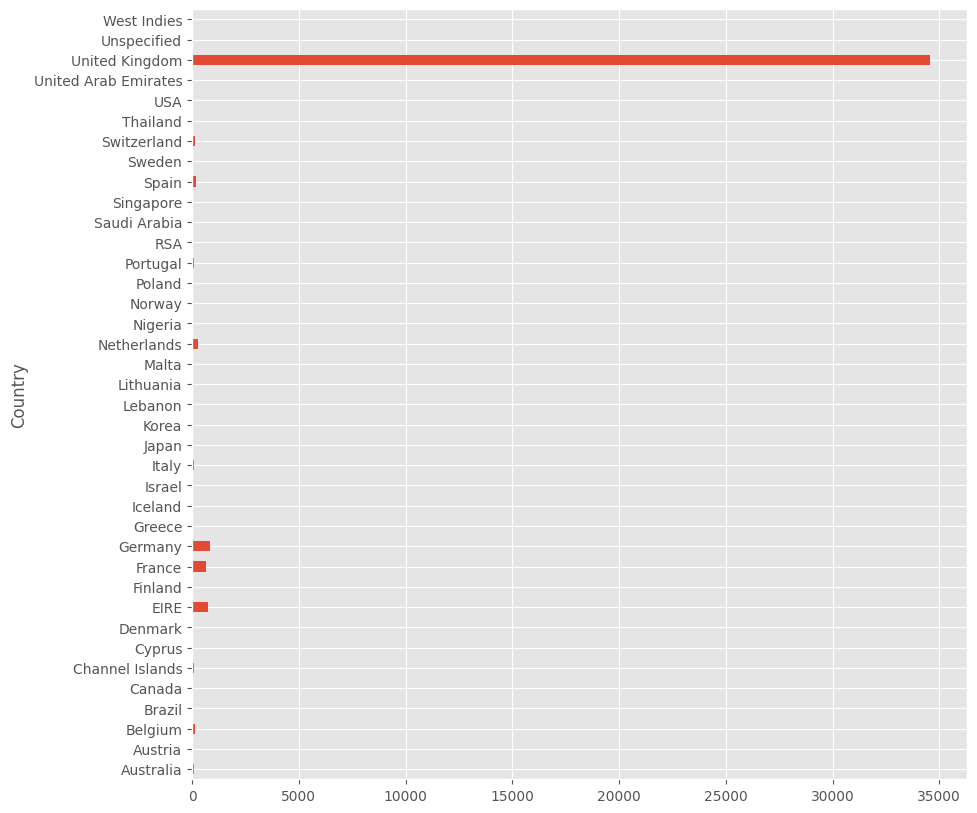

In [14]:
# Plot Countries
plt.style.use('ggplot')
plt.figure(figsize= (10,10))
plt.xlabel('Count')
temp['Country'].value_counts().plot(kind = 'barh', grid = True)
plt.show()

In [15]:
Country_n = []
for item in df_initial['Country']:
    if item == 'United Kingdom' :
        Country_n.append('UK')
    else:
        Country_n.append('Non_UK')
df_initial['Country_n'] = Country_n

In [16]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['Invoice'].value_counts()),
               'customers': len(df_initial['Customer ID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3605,19591,4653


In [17]:
OrderCanceled = []
for item in df_initial['Invoice']:
    if 'C' in str(item):
        OrderCanceled.append(1)
    else:
        OrderCanceled.append(0)
df_initial['OrderCancelled'] = OrderCanceled 

In [18]:
(df_initial['OrderCancelled'] == 1).sum()/(df_initial['Invoice'].shape[0])

0.022410927599459854

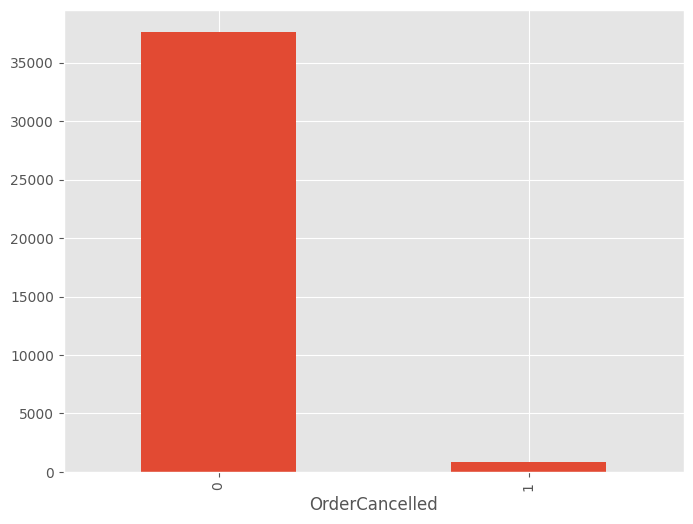

In [19]:
plt.figure(figsize= (8,6))
plt.xlabel('Count')
df_initial['OrderCancelled'].value_counts().plot(kind = 'bar', grid = True)
plt.show()

In [20]:
df_initial.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Country_n,OrderCancelled
0,529196,85132B,CHARLIE AND LOLA TABLE TINS,1,2010-10-27 08:36:00,9.95,12537.0,Sweden,Non_UK,0
1,547891,22029,SPACEBOY BIRTHDAY CARD,12,2011-03-28 10:14:00,0.42,13266.0,United Kingdom,UK,0
3,549169,21034,REX CASH+CARRY JUMBO SHOPPER,3,2011-04-06 17:25:00,0.95,17906.0,United Kingdom,UK,0
4,525733,21035,SET/2 RED RETROSPOT TEA TOWELS,2,2010-10-06 16:17:00,2.95,17006.0,United Kingdom,UK,0
5,548728,21864,UNION JACK FLAG PASSPORT COVER,6,2011-04-04 09:55:00,2.10,13198.0,United Kingdom,UK,0


In [21]:
df_initial['Season_month'] = df_initial['InvoiceDate'].dt.month

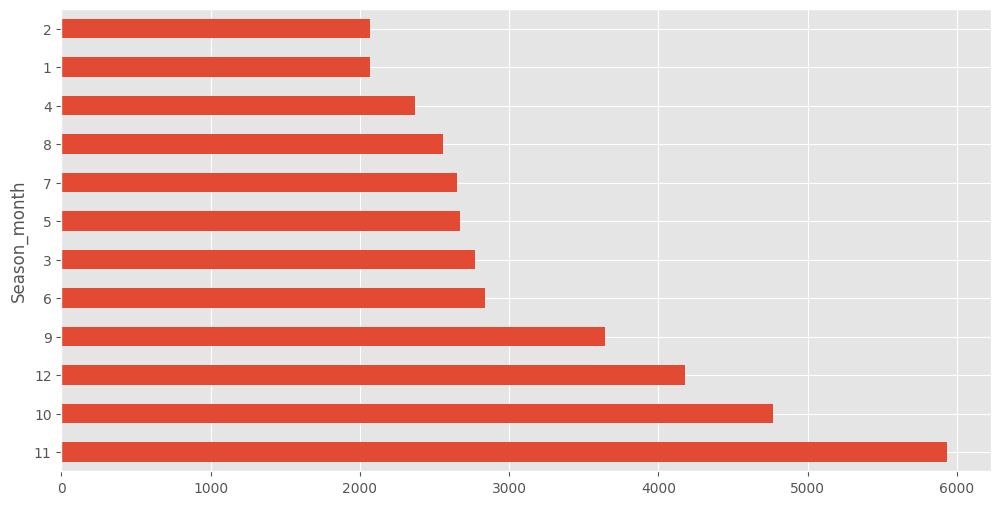

In [22]:
plt.figure(figsize= (12,6))
plt.xlabel('Count')
df_initial['Season_month'].value_counts().plot(kind = 'barh', grid = True)
plt.show()

In [23]:
Quarter = []
for item in df_initial['Season_month']:
    if item < 4 :
        Quarter.append('Q1')
    elif item < 7:
        Quarter.append('Q2')
    elif item < 10:
        Quarter.append('Q3')
    else:
        Quarter.append('Q4')

In [24]:
df_initial['Quarter_y'] = Quarter

In [25]:
Counts = df_initial['StockCode'].value_counts().to_dict()

In [26]:
Categ1 = [];Categ2 = [];Categ3 = [];Categ4 = []
for key,value in Counts.items():
    if value < 25:
        Categ4.append(str(key))
    elif value <= 50:
        Categ3.append(str(key))
    elif value <= 200:
        Categ2.append(str(key))
    else :
        Categ1.append(str(key))

In [27]:
Product_Categ = []
for item in df_initial['StockCode']: 
    if item in Categ1:
        Product_Categ.append(0)
    elif item in Categ2:
        Product_Categ.append(1)
    elif item in Categ3:
        Product_Categ.append(2)
    else:
        Product_Categ.append(3)

In [28]:
len(Product_Categ)

38508

In [29]:
df_initial['Prod_Categ'] = Product_Categ

In [30]:
df_initial.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Country_n,OrderCancelled,Season_month,Quarter_y,Prod_Categ
0,529196,85132B,CHARLIE AND LOLA TABLE TINS,1,2010-10-27 08:36:00,9.95,12537.0,Sweden,Non_UK,0,10,Q4,3
1,547891,22029,SPACEBOY BIRTHDAY CARD,12,2011-03-28 10:14:00,0.42,13266.0,United Kingdom,UK,0,3,Q1,2
3,549169,21034,REX CASH+CARRY JUMBO SHOPPER,3,2011-04-06 17:25:00,0.95,17906.0,United Kingdom,UK,0,4,Q2,1
4,525733,21035,SET/2 RED RETROSPOT TEA TOWELS,2,2010-10-06 16:17:00,2.95,17006.0,United Kingdom,UK,0,10,Q4,2
5,548728,21864,UNION JACK FLAG PASSPORT COVER,6,2011-04-04 09:55:00,2.10,13198.0,United Kingdom,UK,0,4,Q2,3


(-5000.0, 5000.0)

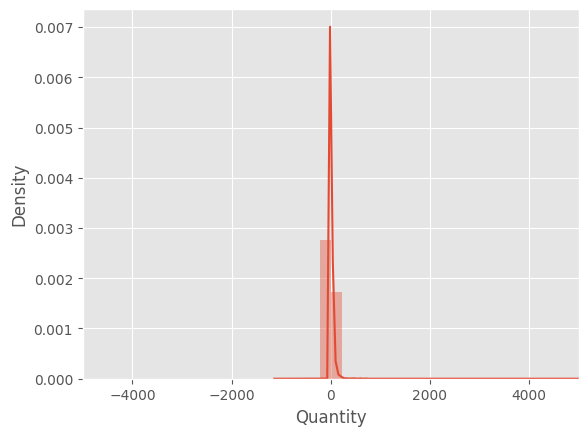

In [31]:
sns.distplot(df_initial["Quantity"])
plt.xlim(-5000,5000)

(0.0, 500.0)

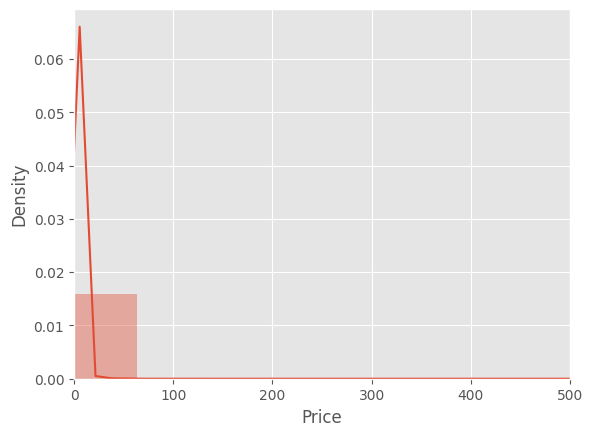

In [32]:
sns.distplot(df_initial["Price"])
plt.xlim(0,500)

In [33]:
X = df_initial.drop(['Invoice','StockCode','Description','InvoiceDate','Customer ID','Country','Season_month','Prod_Categ'], axis = 1)
y = df_initial['Prod_Categ']

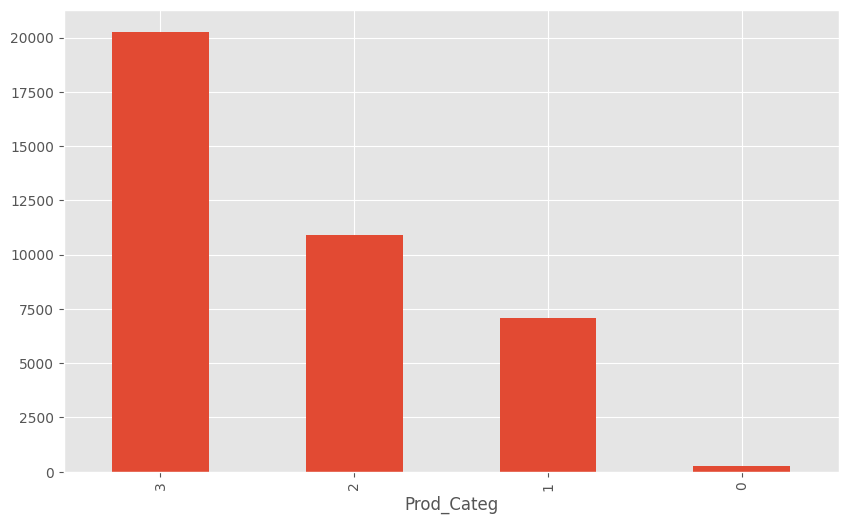

In [34]:
plt.figure(figsize= (10,6))
plt.xlabel('Count')
y.value_counts().plot(kind = 'bar', grid = True)
plt.show()

In [35]:
categorical = ['OrderCancelled','Quarter_y', 'Country_n']
categorical_variables = categorical
X = pd.get_dummies(X, columns = categorical_variables)

In [36]:
#label encoder
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)

In [37]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [38]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [39]:
from tensorflow.keras.utils import to_categorical

2025-11-25 20:18:30.268683: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [40]:

# Example usage
y_train_categorical = to_categorical(y_train)

In [41]:

# Define a function to encode labels for neural networks
def encode_neural_net_y(y):
    encoder = LabelEncoder()
    encoder.fit(y)
    encoded_y = encoder.transform(y)
    new_y = to_categorical(encoded_y)
    return new_y

# Encoding y_train and y_test
y_train = encode_neural_net_y(y_train)
y_test = encode_neural_net_y(y_test)


In [42]:
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (30806, 10)
Shape of y_train:  (30806, 4)
Shape of X_test:  (7702, 10)
Shape of y_test:  (7702, 4)


In [43]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization

# Create the model
model = Sequential()

# Add layers to the model
model.add(Dense(64, activation='relu', input_dim=100))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [44]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,785 (26.50 KB)

 Trainable params: 6,657 (26.00 KB)

 Non-trainable params: 128 (512.00 B)

In [45]:
from keras.models import Sequential
from keras.layers import Dense

# Create model
model = Sequential()

# Add input layer
model.add(Dense(35, input_dim=10, activation='relu'))

# Add hidden layers
model.add(Dense(8, activation='relu'))
model.add(Dense(6, activation='relu'))

# Add output layer
model.add(Dense(4, activation='sigmoid'))  # Output layer with 4 units for multi-class classification

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [46]:
scores = model.evaluate(np.array(X_test), np.array(y_test), verbose=0)
print("====================[TEST SCORE]====================")
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

====================[TEST SCORE]====================
compile_metrics: 51.58%


In [47]:
scores = model.evaluate(np.array(X_train), np.array(y_train), verbose=0)
print("====================[TRAIN SCORE]====================")
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

====================[TRAIN SCORE]====================
compile_metrics: 52.08%


In [48]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Create model
model_alt = Sequential()

# Add input layer
model_alt.add(Dense(10, input_dim=10, activation='relu'))

# Add hidden layers
model_alt.add(Dense(16, activation='relu'))
model_alt.add(Dropout(0.2))  # Adding dropout for regularization
model_alt.add(Dense(12, activation='relu'))
model_alt.add(Dropout(0.2))  # Adding dropout for regularization

# Add output layer
model_alt.add(Dense(4, activation='softmax'))  # Output layer with 4 units for multi-class classification

# Compile model
model_alt.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

scores = model.evaluate(np.array(X_test), np.array(y_test), verbose=0)
print("====================[TEST SCORE]====================")
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

scores = model.evaluate(np.array(X_train), np.array(y_train), verbose=0)
print("====================[TRAIN SCORE]====================")
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

====================[TEST SCORE]====================
compile_metrics: 51.58%
====================[TRAIN SCORE]====================
compile_metrics: 52.08%


In [49]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler

# Normalize input data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create model
model = Sequential()

# Add input layer
model.add(Dense(10, input_dim=10, activation='relu'))

# Add hidden layers
model.add(Dense(16, activation='relu'))
model.add(Dense(12, activation='relu'))

# Add output layer
model.add(Dense(4, activation='softmax'))  # Output layer with 4 units for multi-class classification

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=30, batch_size=40, verbose=1, validation_data=(X_test_scaled, y_test))


Epoch 1/30
771/771 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5275 - loss: 1.0628 - val_accuracy: 0.5230 - val_loss: 1.0387
Epoch 2/30
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5278 - loss: 1.0364 - val_accuracy: 0.5229 - val_loss: 1.0374
Epoch 3/30
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5278 - loss: 1.0355 - val_accuracy: 0.5227 - val_loss: 1.0374
Epoch 4/30
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5277 - loss: 1.0353 - val_accuracy: 0.5227 - val_loss: 1.0358
Epoch 5/30
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5278 - loss: 1.0342 - val_accuracy: 0.5229 - val_loss: 1.0351
Epoch 6/30
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5277 - loss: 1.0335 - val_accuracy: 0.5225 - val_loss: 1.0360
Epoch 7/30
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5275 - loss: 1.0327 - val_accuracy: 0.5226 - val_loss: 1.0342
Epoch 8/30
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5277 - loss: 1.0318 - val_accuracy: 0.

In [50]:
scores = model.evaluate(np.array(X_test), np.array(y_test), verbose=0)
print("====================[TEST SCORE]====================")
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

scores = model.evaluate(np.array(X_train), np.array(y_train), verbose=0)
print("====================[TRAIN SCORE]====================")
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

====================[TEST SCORE]====================
compile_metrics: 52.51%
====================[TRAIN SCORE]====================
compile_metrics: 52.94%
